# **Universal Sentence Encoder Heat Map + Clusters/Topic Modeling**

Before starting make sure you upload the Excel file to this runtime.

File named: "FSN EGM IE data for ML group.xlsx"

In [1]:
#@title Import libraries

import pandas as pd
import numpy as np
import os 
from os import listdir
from os.path import isfile, join, isdir, split
import tensorflow_hub as hub
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
sns.set_theme()
os_path=os.getcwd()
import matplotlib.pyplot as plt
from sklearn import manifold

In [2]:
#@title Select variables
sort_variable= 'intervention' #@param ['intervention', 'Intervention_subdomain']
file_path= join(os_path,"FSN EGM IE data for ML group.xlsx")
data=pd.read_excel(file_path, sheet_name= 'ie_dta',  engine= 'openpyxl')
!mkdir intervention_embeddings
!mkdir embeddings

In [3]:
# Load pre-trained universal sentence encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [4]:
# Keep only relevant columns
keep_col=['title_name', 'abstract', 'Intervention_domain', 'Intervention_subdomain', 'Intervention_description','intervention', 'outcome_type','Outcome_description','outcome_group X','outcome__subgroup']
data=data[keep_col]

# Remove rows that don't contain an abstract, Intervention_description, or Outcome_description
data = data.dropna(subset=['abstract','Intervention_description','Outcome_description'])

# add combined title and abstract column
title_abstract = data.loc[:,('title_name')]+ '. ' + data.loc[:,('abstract')]
data['title abstract'] = title_abstract

# Remove accent marks
cols = data.select_dtypes(include=[np.object]).columns
data[cols] = data[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

#remove nans
data = data.fillna('')

# Sort data by intervention_subdomain

# actually sort by intervention
sorted_data= data.sort_values(by=[sort_variable])

interventions=[]
inter_options= sorted_data[sort_variable]


for index, val in inter_options.iteritems() :
    if val not in interventions:
        interventions.append(val)

In [5]:

#create a list called dfs of all ~9~ dataframes for each intervention with their name as a tuple
dfs=[]
for int_type in interventions:
    name=int_type
    print(int_type)
    # df = data.loc[data['Intervention_subdomain'] == int_type]
    df = sorted_data.loc[sorted_data[sort_variable] == int_type]
    dfs.append((df, name))
    print(df.shape)

#%% Export dataframes 
for i,name in dfs:
    print(name)
    i.to_excel(join(os_path, join('{}_embeddings'.format(sort_variable), "{}_title_abstract.xlsx".format(name.replace('/', '')))))


AAA. Provision of improved water access and management systems
(1, 11)
AABa. Provision of free or reduced-cost access to improved seed varieties
(3, 11)
AABd. Provision of free or reduced-cost access to livestock
(2, 11)
AABe. Provision of free or reduced-cost access to other/unspecified agricultural inputs
(4, 11)
AADa. Education / information - Farmer field schools
(3, 11)
AADb. Education / information - Agricultural extension programs
(2, 11)
AADc. Education / information - information/guidance
(1, 11)
AADd. Education / information - other educational programs
(2, 11)
AAEa. Other efforts to improve the production system- insurance
(2, 11)
ABA. Support for creating storage structures at farms
(1, 11)
ACA. Fortification
(74, 11)
BAB. Governmental price manipulations (excluding tariffs)
(1, 11)
BAC. Direct provision of foods
(25, 11)
BAD. Cash-for-food programs
(3, 11)
BAE. Provision or use of supplements
(49, 11)
CAA. Efforts to increase women's empowerment
(1, 11)
CBA. Peer support /

In [6]:

#%% 
# dfs is defined in intervention_similarity script, but I didn't want to read 
# all the excels in this time. In the future, add this code to that script or
# read those files in

embedded=[]
embed_dfs=[]
useful_dfs=dfs[1:]
for i,name in useful_dfs:
    text=i['title abstract'].tolist()
    embeddings=embed(text)
    embeddings_array=embeddings.numpy()
    embeddings_df=pd.DataFrame(embeddings_array)
    print(name)
    print(embeddings_df.shape)
    embeddings_df.to_excel("embeddings/ {}_text_embeddings.xlsx".format(name.replace('/', '')))
    embedded.append((embeddings,name))
    embed_dfs.append((embeddings_df, name))

AABa. Provision of free or reduced-cost access to improved seed varieties
(3, 512)
AABd. Provision of free or reduced-cost access to livestock
(2, 512)
AABe. Provision of free or reduced-cost access to other/unspecified agricultural inputs
(4, 512)
AADa. Education / information - Farmer field schools
(3, 512)
AADb. Education / information - Agricultural extension programs
(2, 512)
AADc. Education / information - information/guidance
(1, 512)
AADd. Education / information - other educational programs
(2, 512)
AAEa. Other efforts to improve the production system- insurance
(2, 512)
ABA. Support for creating storage structures at farms
(1, 512)
ACA. Fortification
(74, 512)
BAB. Governmental price manipulations (excluding tariffs)
(1, 512)
BAC. Direct provision of foods
(25, 512)
BAD. Cash-for-food programs
(3, 512)
BAE. Provision or use of supplements
(49, 512)
CAA. Efforts to increase women's empowerment
(1, 512)
CBA. Peer support / counsellors
(8, 512)
CBB. Professional services (dietic

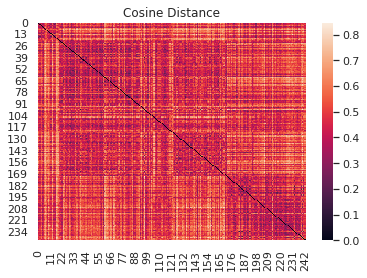

In [ ]:
    
#%%   Concatenate the matrices
combined = pd.concat([embed_df[0] for embed_df in embed_dfs])
    
#%% find cosine distance for entire matrix
cos_sim=cosine_similarity(combined)
cos_dist=1-cos_sim

#%% Seaborn heat map
ax = sns.heatmap(cos_dist).set(title='Cosine Distance')

#%% chamfer distance 

def chamf_dist(df):
  # takes in a rectangular matrix df and finds the minimum cosine distance in each row
  diag=df.shape[0]
  # to make sure we do not use the doc compared to itself
  # df=df+2*np.eye(diag)
  min_value_series= df.min(axis=1)
  return min_value_series


In [ ]:

#%% Iterate through each pair of interventions and find the chamfer distance

#for df, name in embed_dfs:
#    pd.concat()
# for i in range(len(embed_dfs)-1):
#     df1= embed_dfs[i][0]
#     name_1=embed_dfs[i][1]
#     df2= embed_dfs[i+1][0]
#     name_2=embed_dfs[i+1][1]
#     combined=pd.concat([df1,df2])
#     cos_sim=cosine_similarity(combined)
#     cos_dist=1-cos_sim
#     plt.figure(i)
#     sns.heatmap(cos_dist,vmin=0, vmax=1).set(title='Cosine Distance for {} and {}'.format(name_1[:20],name_2[:20]))

n=0
chamfs=[]
for i in range(len(embed_dfs)): #len(embed_dfs)-1): if we are doing the original triangular way
    df1= embed_dfs[i][0]
    num_df1_docs= df1.shape[0]
    name_1=embed_dfs[i][1]
    avg_chamfs=[]
    # for j in range(i+1,len(embed_dfs)):
    #     df2= embed_dfs[j][0]
    #     name_2=embed_dfs[j][1]
    #     combined=pd.concat([df1,df2])
    #     cos_sim=cosine_similarity(combined)
    #     cos_dist=1-cos_sim
    #     n=n+1
        
    #     # plt.figure(n)
    #     # sns.heatmap(cos_dist,vmin=0, vmax=1).set(title='Cosine Distance for {} and {}'.format(name_1[:20],name_2[:20]))
    #     chamfer_distances=chamf_dist(cos_dist)
    #     average_chamf=np.mean(chamfer_distances)
    #     # avg_chamfs.append((average_chamf, name_2)) #if we want names
    #     avg_chamfs.append(average_chamf)
    # # chamfs.append((name_1, avg_chamfs)) #if we want names
    for j in range(len(embed_dfs)):
        if j != i:
            df2= embed_dfs[j][0]
            name_2=embed_dfs[j][1]
            combined=pd.concat([df1,df2])
            cos_sim=cosine_similarity(combined)
            cos_dist=1-cos_sim
            n=n+1
        
        # plt.figure(n)
        # sns.heatmap(cos_dist,vmin=0, vmax=1).set(title='Cosine Distance for {} and {}'.format(name_1[:20],name_2[:20]))
            #chamfer_distances=np.array([chamf_dist(cos_dist)])
            cos_dist_a=cos_dist[:num_df1_docs,num_df1_docs:]
            cos_dist_b=cos_dist[num_df1_docs:,:num_df1_docs]
            #now find chamfer distances
            chamfer_distances_a=chamf_dist(cos_dist_a)
            chamfer_distances_b=chamf_dist(cos_dist_b)
            chamfer_distances_stacked=np.concatenate((chamfer_distances_a,chamfer_distances_b), axis=None)
            average_chamf=np.mean(chamfer_distances_stacked)
        else: 
            average_chamf= 0
        # avg_chamfs.append((average_chamf, name_2)) #if we want names
        avg_chamfs.append(average_chamf)
    # chamfs.append((name_1, avg_chamfs)) #if we want names
    chamfs.append(avg_chamfs)

# chamfs is a list of tuples, the second item in the tuple is also a tuple. 
# chamfs is the length of the number of intervention categories and the first entry has the most comparisons in the second tuple, since it is compared against all following intervention classes. The next one is compared to all following it (so one less than the first) and so on   
    

In [ ]:

#%% NEW PLAN: using the full cosine distance matrix (247x247) we will 
#%%   Manipulate chamfs into a dataframe, first via numpy arrays 

col_names=interventions[1:]

b=np.zeros((len(col_names),len(col_names)))

#iterate over the interventions for which we have the chamfer distances
for col in range(len(chamfs)):
    b[col]=chamfs[col]
# for col in range(len(chamfs)):
#     b[col+1:,col]=chamfs[col]

#b should be a lower diagonal matrix
#%% Make dataframe from b - export to excel
df=pd.DataFrame(data=b, index=col_names, columns=col_names)
chamf_dist_path=join(os_path,'intervention_chamfer_distance')

try:
    os.mkdir(chamf_dist_path)
except OSError as error:
    print(error) 
    
df.to_excel(join(chamf_dist_path, 'intervention_chamfer_dist_3.xlsx'))

# **Clustering**

In [7]:
#@title Install libraries
%%capture
!pip install hdbscan
!pip install umap-learn

In [9]:
#@title Select field to cluster by
field = 'Outcome_description' #@param ['abstract','Intervention_description','Outcome_description']
col_data = data[field]
col_data = [str(d) for d in col_data]
print('Samples from column:', field)
print('--------------------')
for i in range(5):
  print(col_data[i])

Samples from column: Outcome_description
--------------------
We used the value of crop production and the value of livestock produced to measure the impact of farmer field schooling on agricultural income. P23
Evaluate the impact of oportunidades (CCT) on the birth weight of children from poor rural familiesand examine the pathways by which the improvements occurred. P. 51-52
The study evaluated the effect on micronutrient status of a micronutrient-fortified biscuit, given to primary school children, over a period of 2.5 years. P.1204
Height and sitting height were measured by the same observer (QZ) with the use of the same stadiometer in the hospital where the bone densitometry scans were made Pp715.
volume of commercial fertilizer sales for distributors. pp28
volume of total fertilizer sales for larger-scale distributors. Pp29.
commercial fertilizer sales by independent agro-dealers. Pp30.


In [10]:
#@title Embed input data
embeddings = embed(col_data)

In [11]:
#@title Cluster embeddings using HDBSCAN or KMeans
#@markdown Specifying num_clusters only applies to KMeans
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn import preprocessing
from hdbscan import HDBSCAN

clustering_method = "KMeans" #@param ['KMeans','HDBSCAN']
num_clusters =   8#@param {type:"integer"}

if clustering_method == "HDBSCAN":

  distance = pairwise_distances(embeddings, metric='cosine')
  clusterer = HDBSCAN(min_cluster_size=5,
                            min_samples=2,
                            metric='precomputed')

  cluster = clusterer.fit(distance.astype('float64'))

elif clustering_method == "KMeans":
  cluster = KMeans(n_clusters=num_clusters)
  cluster.fit( preprocessing.normalize(embeddings) )

In [12]:
#@title Create dictionary for all clusters 
#@markdown Creates dictionary entry where cls_dict[cluster_num] contains the strings in the cluster

cls_dict = {}

print( f'Number of clusters: {max(cluster.labels_)+1}')

for i in range( -1, max(cluster.labels_)+1 ):
  cls_dict[i] = {}
  cls_dict[i]['strings'] = []

for i, cls in enumerate( cluster.labels_):
  cls_dict[cls]['strings'].append( col_data[i] )

for key in cls_dict:

  cls_center_x = 0
  cls_center_y = 0

cluster_sizes = []
for key in cls_dict:
  if key != -1:
    cluster_sizes.append( len(cls_dict[key]['strings']) )
print( f'Largest cluster size: {max(cluster_sizes)}')
print( f'Smallest cluster size: {min(cluster_sizes)}')
print( f'{len(cls_dict[-1]["strings"])} unclustered out of {len(cluster.labels_)}')

Number of clusters: 8
Largest cluster size: 44
Smallest cluster size: 18
0 unclustered out of 244


In [ ]:
#@title Create 2-D projection
from umap import UMAP
umap_data = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])

result['clusters'] = cluster.labels_
result['string'] = col_data

In [ ]:
#@title Get top words to describe topic { form-width: "50%", display-mode: "form" }

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1),group_by='Topic'):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20,group_by='Topic'):
    words = count.get_feature_names()
    labels = list(docs_per_topic[group_by])
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df,group_by='Topic'):
    topic_sizes = (df.groupby([group_by])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({group_by: group_by, "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes



docs_df = pd.DataFrame({'Doc':col_data,
                        'Topic':cluster.labels_})
docs_df['Doc_ID'] = range(len(docs_df))


# Groups top_n_words for each cluster
group_by = 'Topic'
docs_per_topic = docs_df.groupby([group_by], as_index = False).agg({'Doc': ' '.join})
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(col_data),group_by=group_by)
cls_top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20,group_by=group_by)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#@title Create df for cluster centroids and labels
#@markdown For labeling most common words in the center of the clusters 

cluster_info_df = pd.DataFrame(columns = ['label','x','y','words'])

for key in cls_dict:
  if key != -1:
    cluster_data = result.loc[result['clusters']==key]
    cluster_x = sum( cluster_data['x'] ) / len(cluster_data['x'])
    cluster_y = sum( cluster_data['y'] ) / len(cluster_data['y'])
    cls_dict[key]['center_x'] = cluster_x
    cls_dict[key]['center_y'] = cluster_y

    cls_words = ''
    for (word, score) in cls_top_n_words[key][:5]:
      cls_words += word + ', '
    cls_words = cls_words[:-2]
    cls_dict[key]['words'] = cls_words

    cls_strings = cls_dict[key]['strings']

    cluster_info_df = cluster_info_df.append({'clusters':key,'x':cluster_x,'y':cluster_y,'words':cls_words,'strings':cls_strings},ignore_index=True)

In [ ]:
#@title Define colors for clusters { form-width: "50%", display-mode: "form" }
import colorsys
def get_N_HexCol(N=5):
    HSV_tuples = [(x * 1.0 / N, x * 1.0 / N, x * 1.0 / N) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    return hex_out

color_domain = [i for i in range(-1,max(result['clusters']))]
color_range = ['#e9f0ea']
color_range.extend(get_N_HexCol(max(result['clusters'])))

In [ ]:
#@title Show cluster chart { form-width: "50%", display-mode: "form" }

import altair as alt

cluster_selection = alt.selection_multi(fields=['clusters'])
color = alt.condition(cluster_selection,
                      alt.Color('clusters:N',scale=alt.Scale(domain=color_domain,range=color_range),legend=None),
                      alt.value('lightgray'))
size = alt.condition(cluster_selection,
                     alt.value(250),
                     alt.value(100))
text_size = alt.condition(cluster_selection,
                          alt.value(18),
                          alt.value(0))

chart = alt.Chart( result ).mark_circle(size=150,opacity=0.5).encode(
    x = alt.X('x:Q',title=None, scale=alt.Scale(zero=False), axis=alt.Axis(titlePadding=20)),
    y = alt.Y('y:Q',title=None, scale=alt.Scale(zero=False), axis=alt.Axis(titlePadding=20)),
    color = color,
    size = size,
    tooltip = alt.Tooltip(['string','clusters'])
).add_selection(alt.selection_single())

txt_chart = alt.Chart(cluster_info_df).mark_text(align='left').encode(
    x = alt.X('x:Q',title=None, scale=alt.Scale(zero=False), axis=alt.Axis(titlePadding=20)),
    y = alt.Y('y:Q',title=None, scale=alt.Scale(zero=False), axis=alt.Axis(titlePadding=20)),
    text = 'words',
    size = text_size
).add_selection(alt.selection_single())

cluster_selector = alt.Chart( result ).mark_rect().encode(
    y=alt.Y('clusters:N',
        title=None,
        axis=alt.Axis( 
            labelFontSize=16,
            labelLimit=0,
            orient='right'
        ),
        stack="zero"),
    color=color
).add_selection(
    cluster_selection
).properties(
    title='Clusters'
)

both = alt.layer(
    chart,
    txt_chart
).resolve_scale(
    color='independent',
    shape='independent'
).properties(
    title = f"Clusters and most common words for the {field}" #@param {type:'string'}
    ,width = 800,
    height = 800,
).add_selection(
    cluster_selection
)

all = (both | cluster_selector).configure_axis(
    titleFontSize = 16
).configure_title(
    fontSize = 24, 
    dy=-10
).configure_legend(
    labelFontSize=16,
    titleFontSize=20
)

all

alt.HConcatChart(...)

In [21]:
#@title Show documents in cluster
cluster_num = 2 #@param [-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25] {type:'raw'}
for s in cls_dict[cluster_num]['strings']:
  print(s + '\n')

Height and sitting height were measured by the same observer (QZ) with the use of the same stadiometer in the hospital where the bone densitometry scans were made Pp715.

We want to measure the effect of different extension treatments on farmersaTM adoption of the biofortified bean variety KK15. We use two indicators of technology adoption: (i) adoption of KK15 expressed as a dummy variable that takes a value of one if a household planted KK15 during the study period and zero otherwise; (ii) intensity of adoption measured in terms of the percentage share of total cultivated land under KK15. p 104.

ChildrenaTMs weights and heights or lengths were assessed at baseline and during the second week of each month for a period of 1 year. p 147

Hb concentration and iron status (transferrin saturation and serum ferritin, iron, and transferrin receptor concentrations) was assessed at baseline and again after 34 wk of intervention. p 783. 

Weight was measured (in light clothing) to the nearest 

In [ ]:
#Cluster by outcome_subgroup X


,title_name,abstract,Intervention_domain,Intervention_subdomain,Intervention_description,intervention,outcome_type,Outcome_description,outcome_group X,outcome__subgroup,title abstract
0,Impact of Farmer Field Schools on Agricultural...,Farmer field schools (FFSs) are a popular educ...,A._Food_Supply_Chain,AA._Production_system_,Farmer field schools are traditionally an adul...,AADa. Education / information - Farmer field s...,H._Intermediate,We used the value of crop production and the v...,HA._Economic,HAC._Output_value,Impact of Farmer Field Schools on Agricultural...
9,Empowering Women: How Mexico's Conditional Cas...,Data from a controlled randomised trial are us...,B._Food_Enviroment,BA._Availability_and_affordability,Oportunidades provides cash trans- fers condit...,BAD. Cash-for-food programs,I._Final,Evaluate the impact of oportunidades (CCT) on ...,IA._Anthropometric,IAE._Birth_outcomes,Empowering Women: How Mexico's Conditional Cas...
13,Long-Term Evaluation of a Micronutrient-Fortif...,Objective: To evaluate the long-term effect on...,A._Food_Supply_Chain,AC. Processing and packaging,The aim of the present study therefore was to ...,ACA. Fortification,I._Final,The study evaluated the effect on micronutrien...,IC._Micronutrient_status_,ICA._Iron,Long-Term Evaluation of a Micronutrient-Fortif...
20,"Growth, Bone Mass, and Vitamin D Status of Chi...",Background: A 2-y school milk intervention tri...,B._Food_Enviroment,BA._Availability_and_affordability,In a school milk intervention study conducted ...,BAC. Direct provision of foods,I._Final,Height and sitting height were measured by the...,IA._Anthropometric,IAA._Linear_growth,"Growth, Bone Mass, and Vitamin D Status of Chi..."
32,Supply-Side CrowdingaOut and CrowdingaIn Effec...,The present article estimates the extent to wh...,A._Food_Supply_Chain,AA._Production_system_,The objective of the present study is to provi...,AABe. Provision of free or reduced-cost access...,H._Intermediate,volume of commercial fertilizer sales for dist...,HA._Economic,HAA._Income,Supply-Side CrowdingaOut and CrowdingaIn Effec...
37,Effect of Iron Fortification and De-worming on...,Previous data from Vietnam show that anaemia i...,A._Food_Supply_Chain,AC. Processing and packaging,The present study aimed to evaluate the hypoth...,ACA. Fortification,I._Final,Outcomes considered were change in haematologi...,IC._Micronutrient_status_,ICA._Iron,Effect of Iron Fortification and De-worming on...
43,Field Trial of a Synthetic Tsetse-Repellent Te...,We conducted a field trial among Maasai cattle...,A._Food_Supply_Chain,AA._Production_system_,They used an intervention to prevent trypanoso...,AABe. Provision of free or reduced-cost access...,H._Intermediate,Trypanosome infection incidence per animal per...,HB._Agricultural,HBB._Animal_husbandry,Field Trial of a Synthetic Tsetse-Repellent Te...
55,A Comparison of the Bioavailability of Ferrous...,Background/Objectives: Ferrous fumarate is rec...,A._Food_Supply_Chain,AC._Processing_and_packaging_,The aim of the present study was to further ev...,ACA. Fortification,I._Final,Stable isotopes were used to compare iron abso...,IC._Micronutrient_status_,ICA._Iron,A Comparison of the Bioavailability of Ferrous...
64,Crop Price Indemnified Loans For Farmers: A Pi...,Farmers face a particular set of risks that co...,A._Food_Supply_Chain,AA._Production_system_,loans that included crop price indemnification...,AAEa. Other efforts to improve the production ...,H._Intermediate,"Cultivated indemnity crop, garden egg, maize",HB._Agricultural,HBC._Plant/crop_production,Crop Price Indemnified Loans For Farmers: A Pi...
68,Effectiveness of Micronutrient-Fortified Rice ...,Micronutrient deficiency is one of the biggest...,B._Food_Enviroment,BA._Availability_and_affordability,The overall objective of the VGD Programme is ...,BAC. Direct provision of foods,I._Final,inc deficiency is defined as serum zinc level ...,IC._Micronutrient_status_,ICD._Zinc,Effectiveness of Micron

Text(0, 0.5, 'K-Means Objective')

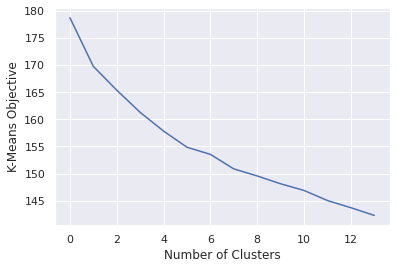

In [ ]:
#Run different number of clusters
cluster_scores = []
for n_clusters in range(1,15,1):
  min_score = float('inf')
  for j in range(10):
    new_cluster = KMeans(n_clusters = n_clusters)
    new_cluster.fit(preprocessing.normalize(embeddings))
    min_score = min(min_score,new_cluster.score(preprocessing.normalize(embeddings)))
  cluster_scores.append(-min_score)

plt.plot(cluster_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('K-Means Objective')

#we should also do qualitative analysis of the different cluster scores, which is probably more relevant than this
#quantitative analysis

# **USE Classifier Training**
For using universal-sentence-encoder embeddings to train a classifier to predict the Intervention and Outcome labels given the texts.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt

In [ ]:
input_column = 'Intervention_description' #@param ['Intervention_description','Outcome_description']
output_column = 'Intervention_subdomain' #@param ['intervention','Intervention_subdomain','outcome_group X','outcome__subgroup']

classifier_data = data[[input_column,output_column]]
classifier_data = classifier_data.sample(frac=1).reset_index(drop=True)

# from sklearn.model_selection import train_test_split
# train, test = train_test_split( classifier_data )
# train_data = train[input_column].values
# train_labels = train[output_column].values
# test_data = test[input_column].values
# test_labels = test[output_column].values

all_feats = classifier_data[input_column].values
all_labels = classifier_data[output_column].values

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
all_labels = label_encoder.transform(all_labels)
# train_labels = label_encoder.transform(train_labels)
# test_labels = label_encoder.transform(test_labels)

num_classes = max(all_labels)+1

from keras.utils import np_utils
all_labels = np_utils.to_categorical(all_labels)
# train_labels = np_utils.to_categorical(train_labels)
# test_labels = np_utils.to_categorical(test_labels)

In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
embedLayer = hub.KerasLayer(module_url, trainable=False, name='USE_embedding')

In [ ]:
def build_model():
    
    model = Sequential()
    model.add(InputLayer(input_shape=[], dtype=tf.string))
    model.add(embedLayer)
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(Adam(2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_embedding (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 8)                 4104      
                                                                 
Total params: 256,801,928
Trainable params: 4,104
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
estimator = KerasClassifier(build_fn=build_model, epochs=250, batch_size=10)
kfold = KFold(n_splits=4, shuffle=True)
results = cross_val_score(estimator, all_feats, all_labels, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# MDS and TSNE Plots

This section uses the output of Section 1 as the input. It requires a symmetric difference matrix.

Can be imported as intervention_chamfer_dist_2_edited.xlsx.

In [ ]:
file_path= "intervention_chamfer_dist_2_edited.xlsx"
chamf_dist=pd.read_excel(file_path, engine= 'openpyxl', index_col='Unnamed: 0')
chamf_dist=chamf_dist.drop(['Unnamed: 22','Unnamed: 23'], axis=1)
chamf_dist=chamf_dist.drop(['Unnamed: 24','Unnamed: 25'], axis=1)

In [ ]:
chamf_dist

,AAA. Provision of improved water access and management systems,AABa. Provision of free or reduced-cost access to improved seed varieties,AABd. Provision of free or reduced-cost access to livestock,AABe. Provision of free or reduced-cost access to other/unspecified agricultural inputs,AADa. Education / information - Farmer field schools,AADb. Education / information - Agricultural extension programs,AADc. Education / information - information/guidance,AADd. Education / information - other educational programs,AAEa. Other efforts to improve the production system- insurance,ABA. Support for creating storage structures at farms,ACA. Fortification,BAB. Governmental price manipulations (excluding tariffs),BAC. Direct provision of foods,BAD. Cash-for-food programs,BAE. Provision or use of supplements,CAA. Efforts to increase women's empowerment,CBA. Peer support / counsellors,CBB. Professional services (dieticians / nurses),CBC. Community meetings,CBD. Classes,CBE. Healthy food social marketing campaigns
AAA. Provision of improved water access and management systems,0.000000,0.368395,0.384668,0.497373,0.521095,0.475950,0.467131,0.512419,0.648594,0.534044,0.446581,0.568982,0.426310,0.483891,0.479169,0.531466,0.469519,0.473942,0.428732,0.467155,0.512791
AABa. Provision of free or reduced-cost access to improved seed varieties,0.368395,0.000000,0.348597,0.389240,0.405106,0.361587,0.338527,0.362359,0.518538,0.496024,0.363742,0.553634,0.364196,0.436648,0.392504,0.395038,0.366787,0.383249,0.380881,0.379615,0.416178
AABd. Provision of free or reduced-cost access to livestock,0.384668,0.348597,0.000000,0.388606,0.347158,0.375506,0.361654,0.486443,0.477415,0.464983,0.448237,0.517366,0.396258,0.448908,0.476909,0.430341,0.387442,0.397022,0.378437,0.377542,0.419227
AABe. Provision of free or reduced-cost access to other/unspecified agricultural inputs,0.497373,0.389240,0.388606,0.000000,0.413601,0.448469,0.439275,0.486813,0.459963,0.545470,0.387079,0.563498,0.390974,0.479237,0.420891,0.525587,0.412762,0.425303,0.444432,0.428087,0.484532
AADa. Education / information - Farmer field schools,0.521095,0.405106,0.347158,0.413601,0.000000,0.420757,0.395109,0.487092,0.408616,0.467285,0.527802,0.599148,0.493947,0.526043,0.556867,0.507822,0.512127,0.517156,0.514780,0.509868,0.522012
AADb. Education / information - Agricultural extension programs,0.475950,0.361587,0.375506,0.448469,0.420757,0.000000,0.441561,0.444334,0.574412,0.559186,0.429749,0.656393,0.426544,0.532718,0.461583,0.489173,0.435390,0.454321,0.438234,0.464166,0.516833
AADc. Education / information - information/guidance,0.467131,0.338527,0.361654,0.439275,0.395109,0.441561,0.000000,0.493719,0.507954,0.474548,0.485927,0.561357,0.432894,0.489186,0.519388,0.474968,0.438195,0.453833,0.411491,0.430973,0.455109
AADd. Education / information - other educational programs,0.512419,0.362359,0.486443,0.486813,0.487092,0.444334,0.493719,0.000000,0.601703,0.581041,0.445112,0.650616,0.412732,0.523411,0.469634,0.574944,0.433164,0.423377,0.489218,0.370435,0.498664
AAEa. Other efforts to improve the production system- insurance,0.648594,0.518538,0.477415,0.459963,0.408616,0.574412,0.507954,0.601703,0.000000,0.549985,0.633712,0.591893,0.600588,0.626598,0.659727,0.604093,0.626685,0.641798,0.645278,0.626017,0.643028
ABA. Support for creating storage structures at farms,0.534044,0.496024,0.464983,0.545470,0.467285,0.559186,0.474548,0.581041,0.549985,0.000000,0.611945,0.475724,0.552854,0.530022,0.653529,0.567135,0.559629,0.571181,0.559359,0.554250,0.555565


In [ ]:
mds = manifold.MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    random_state=42,
    dissimilarity="precomputed",
    n_jobs=1
)
pos = mds.fit(chamf_dist).embedding_

Make MDS Plot


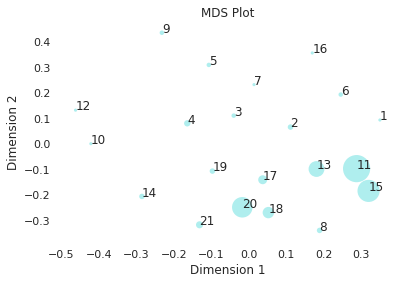

In [ ]:
fig = plt.figure(1)
ax = plt.gca()
s=np.array([1, 3, 2, 4, 2, 2, 1, 3, 2, 1, 74, 1, 25, 3, 49, 1, 8, 13, 3, 42, 5])*10

annotations=chamf_dist.columns.tolist()
plt.scatter(pos[:, 0], pos[:, 1], color="paleturquoise", s=s, lw=0, label="MDS")

#for i, label in enumerate(annotations):
#    plt.annotate(label, (pos[i, 0],pos[i, 1]))
for i in range(len(annotations)):
    plt.annotate(i+1, (pos[i, 0],pos[i, 1]))
plt.title('MDS Plot')
# Hide grid lines
ax.grid(False)

# Hide axes ticks
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_facecolor('white')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.show()

TSNE Plot

In [ ]:
tsne= manifold.TSNE(n_components=2, random_state=42, init='random', metric="precomputed")
X=chamf_dist.to_numpy()
tsne_pos = tsne.fit(X).embedding_

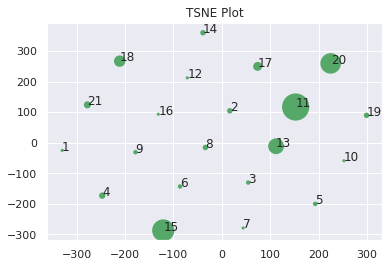

In [ ]:
fig2 = plt.figure(2)
#ax = plt.axes([0.0, 0.0, 1.0, 1.0])
s=np.array([1, 3, 2, 4, 2, 2, 1, 3, 2, 1, 74, 1, 25, 3, 49, 1, 8, 13, 3, 42, 5])*10

annotations=chamf_dist.columns.tolist()
plt.scatter(tsne_pos[:, 0], tsne_pos[:, 1], color="g", s=s, lw=0, label="MDS")

#for i, label in enumerate(annotations):
#    plt.annotate(label, (pos[i, 0],pos[i, 1]))
for i in range(len(annotations)):
    plt.annotate(i+1, (tsne_pos[i, 0],tsne_pos[i, 1]))
plt.title('TSNE Plot')
plt.show()